In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import lightgbm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from scipy.interpolate import UnivariateSpline
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
rep_cols = {'ID':'ID', 
 '板温':'board_t', 
 '现场温度':'env_t', 
 '光照强度':'light_strength', 
 '转换效率':'efficiency', 
 '转换效率A':'efficiency_A', 
 '转换效率B':'efficiency_B', 
 '转换效率C':'efficiency_C', 
 '电压A':'V_A',
 '电压B':'V_B', 
 '电压C':'V_C', 
 '电流A':'I_A', 
 '电流B':'I_B', 
 '电流C':'I_C', 
 '功率A':'P_A', 
 '功率B':'P_B', 
 '功率C':'P_C', 
 '平均功率':'P_avg', 
 '风速':'wind_speed',
 '风向':'wind_direction', 
 '发电量':'y'
}

In [3]:
def my_val(preds, train_data):
    label = train_data.get_label()
    return 'score', 1/(1+np.sqrt(mean_squared_error(preds, label))), True

In [5]:
train = pd.read_csv('../data/public.train.csv')
train['is_train']= 1
test = pd.read_csv('../data/public.test.csv')
test['is_train']=0
train_len = train.shape[0]
df = pd.concat([train, test])
df.reset_index(inplace=True, drop=True)
print(test.shape)

(8409, 21)


In [6]:
df.rename(index=str, columns=rep_cols, inplace=True)

In [7]:
special_missing_test_id = df[(df['P_A']<1)&(df['is_train']==0)]['ID']
print(len(special_missing_test_id))

46


In [8]:
print(df.shape, df[df['is_train']==0].shape)
df.drop(df[(df['P_A']<1)&(df['is_train']>0)].index,inplace=True)
print(df.shape, df[df['is_train']==0].shape)

(17409, 22) (8409, 22)
(17341, 22) (8409, 22)


In [9]:
df.sort_values(by='ID',ascending=True, inplace=True)
df.reset_index(drop=True,inplace=True)

In [10]:
raw_feats = [x for x in df.columns.tolist() if x not in['ID','is_train','y']]

In [11]:
def get_ts_feature(df, f_name, prefix='', v_len = 25):
    v = df[f_name].values.tolist()
    # prev
    temp_list = []
    for i in range(df.shape[0]):
        temp_list.append(v[i-v_len:i][::-1])
    temp_df = pd.DataFrame(temp_list)
    temp_df.columns = [prefix+'prev_%d'%x for x in range(v_len)]
    temp_df['ID'] = df['ID'].values
    
    # succ
    temp_list = []
    for i in range(df.shape[0]):
        temp_list.append(v[i+1:i+v_len+1])
    temp_df2 = pd.DataFrame(temp_list)
    temp_df2.columns = [prefix+'succ_%d'%x for x in range(v_len)]
    temp_df2['ID'] = df['ID'].values
    
    temp_df = temp_df.merge(temp_df2, on='ID', how='left')
    return temp_df

In [12]:
def clean_data_drop(df, clean_cols, correct_dict):
    for c in clean_cols:
        if c in correct_dict.keys():
            df.drop(df[(df[c]>correct_dict[c][1])&(df['is_train']==1)].index,inplace=True)
            df.drop(df[(df[c]<correct_dict[c][0])&(df['is_train']==1)].index,inplace=True)
    return df

In [13]:
def clean_data(df, clean_cols, correct_dict):
    for c in clean_cols:
        upper = df[c].mean()+2*df[c].std()
        lower = df[c].mean()-2*df[c].std()
        df[c+'_is_out_of_upper'] = (df[c]>upper).astype(np.int32)
        df[c+'_is_out_of_lower'] = (df[c]<lower).astype(np.int32)
        df.loc[df[c]>upper,c] = np.nan
        df.loc[df[c]<lower,c] = np.nan
        if c in correct_dict.keys():
            df[c+'_is_out_of_upper'] = (df[c]>correct_dict[c][1]).astype(np.int32)+df[c+'_is_out_of_upper'] 
            df[c+'_is_out_of_lower'] = (df[c]<correct_dict[c][0]).astype(np.int32)+df[c+'_is_out_of_lower'] 
            df.loc[df[c]>correct_dict[c][1],c]=np.nan
            df.loc[df[c]<correct_dict[c][0],c]=np.nan
    return df

In [14]:
#异常值处理
correct_dict = {
    'V_A':(480,60000),
    'V_B':(500,60000),
    'V_C':(500, 60000),
    'env_t':(-30,30),
    'I_B':(0, 600),
    'I_C':(0, 30),
    'P_A':(0,10000),
    'P_B':(0,10000),
    'P_C':(0,10000),
    'P_avg':(0,10000),
    'efficiency_A':(0,100),
    'efficiency_B':(0,100),
    'efficiency_C':(0,100),
    'wind_direction':(0,500)
}
cols = [c for c in df.columns.tolist() if c not in ['is_train','ID','y']]
df = clean_data_drop(df, cols, correct_dict)
df = clean_data(df, cols, correct_dict)

In [15]:
def replace_nan_value(df, cols, replace=True):
    df_len = df.shape[0]
    for c in tqdm(cols):
        i_y =df.columns.get_loc(c)
        next_id = []
        next_one = []
        prev_id = []
        prev_one = []
        for i in range(df_len):
            prev = i-1
            while(prev>=0 and df.iat[prev,i_y]<0):
                prev-=1
            if prev>=0:
                prev_one.append(df.iat[prev,i_y])
                prev_id.append(prev)
            else:
                prev_one.append(np.nan)
                prev_id.append(0)

            next = i+1
            while(next<df_len and df.iat[next,i_y]<0):
                next+=1
            if next<df_len:
                next_one.append(df.iat[next,i_y])
                next_id.append(next)
            else:
                next_one.append(np.nan)
                next_id.append(df_len)

        temp = pd.DataFrame()
        temp['next_value'] = next_one
        temp['prev_value'] = prev_one
        temp['avg_value'] = np.nanmean([temp['next_value'], temp['prev_value']],axis=0)
        temp['next_ID'] = next_id
        temp['prev_ID'] = prev_id
        temp['ID'] = df['ID'].values
        temp['interpolation_value'] = temp['prev_value']+(temp['ID']-temp['prev_ID'])/(temp['next_ID']-temp['prev_ID'])*(temp['next_value']-temp['prev_value'])
        if replace==True:
            df.loc[df[df[c].isnull()].index,c]=temp.loc[df[df[c].isnull()].index,'interpolation_value']
        else:
            df[c+'_interpolation_value'] = temp['interpolation_value'].values
    return df

In [16]:
df = replace_nan_value(df, cols)

/Users/wyh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice


In [17]:
def get_fake_feature(df, f_name):
    a = df['y']
    w=np.isnan(a)
    a[w]=0
    bt=df['ID']
    f=UnivariateSpline(bt,a,w=~w,k=4)
    x = df[['ID']]
    x['fake_'+f_name] = f(bt)
    return x

In [18]:
# x = get_fake_feature(df, 'light_strength')
# df = df.merge(x, on='ID', how='left')

# x = get_fake_feature(df, 'env_t')
# df = df.merge(x, on='ID', how='left')

# x = get_fake_feature(df, 'y')
# df = df.merge(x, on='ID', how='left')

# x = get_fake_feature(df, 'board_t')
# df = df.merge(x, on='ID', how='left')

In [19]:
df.shape

(17032, 60)

In [20]:
for i in range(len(raw_feats)):
    for j in range(i,len(raw_feats)):
        df[raw_feats[i]+'_X_'+raw_feats[j]] = df[raw_feats[i]]*df[raw_feats[j]]

In [21]:
df.shape

(17032, 250)

In [22]:
df.head()

,ID,is_train,light_strength,P_A,P_B,P_C,y,P_avg,board_t,env_t,...,efficiency_B_X_efficiency_B,efficiency_B_X_efficiency_C,efficiency_B_X_wind_direction,efficiency_B_X_wind_speed,efficiency_C_X_efficiency_C,efficiency_C_X_wind_direction,efficiency_C_X_wind_speed,wind_direction_X_wind_direction,wind_direction_X_wind_speed,wind_speed_X_wind_speed
0,1,0,1.0,0.00,0.00,0.00,NaN,0.00,0.01,0.1,...,0.0000,0.0000,NaN,0.000,0.000000,NaN,0.0000,NaN,NaN,0.01
1,9,0,13.0,909.72,148.05,1031.03,NaN,696.27,NaN,-17.5,...,1778.3089,NaN,11512.41,12.651,NaN,NaN,NaN,74529.0,81.9,0.09
5,13,0,50.0,1334.07,200.20,1472.58,NaN,1002.28,NaN,-16.6,...,216.0900,812.8365,4071.90,13.230,3057.537025,15316.715,49.7655,76729.0,249.3,0.81
7,15,1,65.0,1548.51,233.28,1674.40,2.532091,1152.06,-14.60,-16.3,...,171.3481,1229.4128,3665.20,14.399,8820.966400,26297.600,103.3120,78400.0,308.0,1.21
8,16,1,76.0,1619.93,538.72,1723.12,2.779719,1293.92,-14.10,-16.2,...,665.6400,2129.2740,7172.40,23.220,6811.200900,22943.340,74.2770,77284.0,250.2,0.81


In [30]:
x = get_ts_feature(df, 'light_strength', 'ls')
df = df.merge(x, on='ID', how='left')

x = get_ts_feature(df, 'env_t', 'env_t')
df = df.merge(x, on='ID', how='left')

x = get_ts_feature(df, 'env_t', 'board_t')
df = df.merge(x, on='ID', how='left')

x = get_ts_feature(df, 'fake_y', 'fake_y')
df = df.merge(x, on='ID', how='left')

In [21]:
# target = ['P_A','P_avg','I_A','P_C','I_C','P_B','I_B']
# target_plus = [c+'_is_out_of_upper' for c in target]+[c+'_is_out_of_lower' for c in target]+target
# for c in target:
#     df['log_'+c] = np.log1p(df[c])

In [23]:
train = df[df['is_train']==1]
test = df[df['is_train']==0]

In [49]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

X_train, X_test, y_train, y_test = train_test_split(train[predictor], train['y'], test_size=0.2, random_state=123)
sm = SelectFromModel(LGBMRegressor(random_state=2))
# X_train = sm.fit_transform(X_train, y_train)
# X_test = sm.transform(X_test)
# sub_data = sm.transform(sub_data)

In [24]:
# train = sm.fit_transform(X_train, y_train)

In [25]:
test.shape

(8409, 250)

In [26]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'mse',
    'num_leaves': 32,
    'learning_rate': 0.08,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'verbose': 0,
    'lambda_l1':1,
    'lambda_l2':0.1
}

In [27]:
predictor = [c for c in train.columns.tolist() if c not in['ID','y','is_train']]

In [28]:
len(predictor)

247

In [29]:
test_predicts = []
val_preds = []

# log_test_predicts = []
# log_val_predicts = []
for idx, seed in enumerate([1,2,3,4,5]):
    kf = KFold(5, shuffle=True, random_state=seed)
    print('-------------------------------------')
    print('fold:',idx)
    val_preds.append(np.zeros(train.shape[0]))
    for n_fold, (tra_idx, val_idx) in enumerate(kf.split(train)):
        tra = train.iloc[tra_idx]
        val = train.iloc[val_idx]

        train_set = lightgbm.Dataset(
            tra[predictor],
            tra['y']
        )

        validation_set = lightgbm.Dataset(
            val[predictor],
            val['y']
        )

        model = lightgbm.train(params, train_set, num_boost_round=5000,
                              valid_sets= [validation_set],
                              valid_names=['valid'],
                              early_stopping_rounds=100,
                               feval=my_val,
                              verbose_eval=500)

        val_preds[idx][val_idx] = model.predict(val[predictor])
        test_predicts.append(model.predict(test[predictor]))
        
#         train_set = lightgbm.Dataset(
#             tra[predictor],
#             np.log1p(tra['y'])
#         )

#         validation_set = lightgbm.Dataset(
#             val[predictor],
#             np.log1p(val['y'])
#         )

#         model = lightgbm.train(params, train_set, num_boost_round=5000,
#                               valid_sets= [validation_set],
#                               valid_names=['valid'],
#                               early_stopping_rounds=100,
#                                feval=my_val,
#                               verbose_eval=500)

#         val_preds[idx][val_idx] = np.expm1(model.predict(val[predictor]))
#         test_predicts.append(np.expm1(model.predict(test[predictor])))

-------------------------------------
fold: 0
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[391]	valid's l2: 0.0568589	valid's score: 0.80746
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[229]	valid's l2: 0.0118884	valid's score: 0.901686
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[368]	valid's l2: 0.026931	valid's score: 0.859028
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[201]	valid's l2: 0.010009	valid's score: 0.909054
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[385]	valid's l2: 0.0168276	valid's score: 0.885174
-------------------------------------
fold: 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[192]	valid's l2: 0.0175326	valid's score: 0.883072
Training un

In [30]:
print('local cv:',1/(1+np.sqrt(mean_squared_error(train['y'],np.mean(val_preds,axis=0)))))

local cv: 0.866493712002


In [31]:
feat_imp = pd.Series(model.feature_importance(importance_type='gain'),
          index=model.feature_name())
feat_imp.sort_values(ascending=False,inplace=True)
feat_imp.head(20)

P_A_X_P_avg    250730.037094
P_avg_X_I_A     74150.997601
P_avg           65063.734584
P_A_X_P_C       52420.363321
P_avg_X_I_C      6997.200276
P_A              1927.504237
P_A_X_I_B        1909.424036
P_A_X_I_C        1908.679529
P_A_X_P_B        1754.873040
I_A              1230.517274
I_A_X_I_B        1142.366035
P_C_X_I_B        1140.050039
P_A_X_I_A         999.436039
P_avg_X_I_B       629.951483
V_B_X_I_A         450.207919
P_C_X_I_A         426.883810
P_B_X_I_C         308.019844
I_A_X_I_A         289.234758
I_B_X_I_C         280.244920
P_B_X_I_A         268.456967
dtype: float64

In [32]:
feat_imp[feat_imp<1].shape

(81,)

In [33]:
test['ans'] = np.mean(test_predicts, axis=0)

/Users/wyh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
test.loc[test[test['ID'].isin(special_missing_test_id.values.tolist())].index,'ans']=0.379993053

/Users/wyh/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [36]:
test[['ID','ans']].to_csv('../result/0810-8664-goodluck.csv',header=False, index=False)

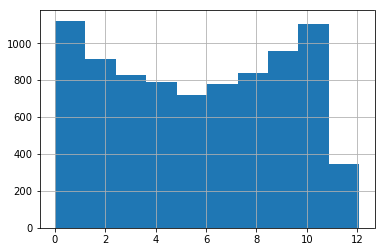

In [37]:
test['ans'].hist()

In [38]:
test['ans'].describe()

count    8409.000000
mean        5.700563
std         3.456362
min         0.009845
25%         2.523996
50%         5.723482
75%         8.894716
max        12.075712
Name: ans, dtype: float64

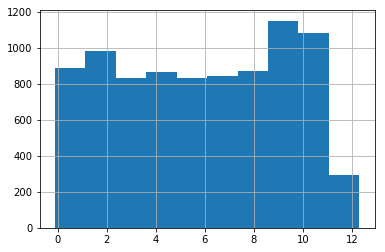

In [39]:
train['y'].hist()

In [40]:
train['y'].describe()

count    8623.000000
mean        5.874755
std         3.409577
min        -0.111311
25%         2.797747
50%         5.993159
75%         9.018946
max        12.288756
Name: y, dtype: float64